
# 1.2.3 Steel Industry Energy Consumption 

## Dataset Context
The **Steel Industry Energy Consumption** dataset was collected from a smart small-scale steel industry in Gwangyang, South Korea (DAEWOO Steel Co. Ltd).  
It contains **35,040 records** describing energy usage, power factors, CO₂ emissions, and load types.

### Objective
Analyze and understand energy consumption patterns in relation to time, power variables, and load type.

Source: [UCI Machine Learning Repository - Steel Industry Energy Consumption](https://archive.ics.uci.edu/dataset/851/steel+industry+energy+consumption)


## Modelo XGBOOST 

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb





### Cargar dataset

In [17]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)

# Load dataset
path = '../../data/raw/steel_energy_original.csv'
df = pd.read_csv(path)

print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

# Asegurar tipado correcto de 'date' (era object)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.head()

Rows: 35040 | Columns: 11


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


### Preprocesamiento

NOTAS: 
1. No se excluyen datos atipicos
2. date se convierte de object a datetime64
3. Se elimina variables con alta correlacion a target = CO2
4. Week_Statua, Day_of_week y Load_Type se codifican como OneHot
5. Predictores X - data, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, Lagging_Current_Power_Factor, Leading_Current_Power_Factor, NSM, WeekStatus, Load_Type
6. Target Y- Usage_kWh


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  13824 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus                            35040 non-null  object        
 9   Day_of_week                           35040 non-null  object        
 10

### Limpieza

In [19]:
# Eliminar filas nulas
df = df.dropna()

# Ordenar cronológicamente
df = df.sort_values(by="date")



### Caracteristicas de tiempo derivadas de 'date'

In [20]:
df['hour'] = df['date'].dt.hour
df['dayofweek_num'] = df['date'].dt.dayofweek  # 0=Mon,...,6=Sun
df['month'] = df['date'].dt.month

### One Hot Encoding para 'WeekStatus, Day_of_week y Load_Type

In [21]:
df = pd.get_dummies(df, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], drop_first=True)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13824 entries, 95 to 33214
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  13824 non-null  datetime64[ns]
 1   Usage_kWh                             13824 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  13824 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  13824 non-null  float64       
 4   CO2(tCO2)                             13824 non-null  float64       
 5   Lagging_Current_Power_Factor          13824 non-null  float64       
 6   Leading_Current_Power_Factor          13824 non-null  float64       
 7   NSM                                   13824 non-null  int64         
 8   hour                                  13824 non-null  int32         
 9   dayofweek_num                         13824 non-null  int32         
 10  mo

In [13]:
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,hour,dayofweek_num,month,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Maximum_Load,Load_Type_Medium_Load
95,2018-01-01 00:00:00,3.42,3.46,0.00,0.0,70.30,100.00,0,0,0,1,False,True,False,False,False,False,False,False,False
0,2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,0,0,1,False,True,False,False,False,False,False,False,False
1,2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,0,1,False,True,False,False,False,False,False,False,False
2,2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,0,0,1,False,True,False,False,False,False,False,False,False
3,2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,1,0,1,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210,2018-12-12 22:45:00,4.25,3.42,0.14,0.0,77.91,99.95,81900,22,2,12,False,False,False,False,False,False,True,True,False
33211,2018-12-12 23:00:00,4.21,3.31,0.18,0.0,78.61,99.91,82800,23,2,12,False,False,False,False,False,False,True,True,False
33212,2018-12-12 23:15:00,4.14,2.88,0.32,0.0,82.09,99.70,83700,23,2,12,False,False,False,False,False,False,True,False,False
33213,2018-12-12 23:30:00,4.10,2.45,0.50,0.0,85.84,99.26,84600,23,2,12,False,False,False,False,False,False,True,False,False


### Division de datos (no-temporizado / basado en features)

In [14]:
#Eliminamos CO2 debido a la alta correlacion
#Eliminamos Day_of_Week

features = [
    # Eléctricas / de estado
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM',
    # Tiempo
    'hour', 'dayofweek_num', 'month',
    # One-hot binaria
    'WeekStatus_Weekend','Load_Type_Maximum_Load',
    'Load_Type_Medium_Load'
]

In [23]:
# Division de datos 80%-20%
target = 'Usage_kWh'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Entrenamiento XGBoost

In [31]:
# Clasificacion
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_train_pred = xgb_model.predict(X_train)

### Evaluacion

In [32]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:,.2f}')
print(f'MAE : {mae:,.2f}')
print(f'R²  : {r2:,.3f}')

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R² :", r2_score(y_test, y_pred))


RMSE: 1.28
MAE : 0.62
R²  : 0.999
Train R²: 0.9996709998200698
Test R² : 0.9986012756801174


In [37]:
#Validacion cruzada 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, scoring='r2', cv=5)
print(scores.mean(), scores.std())

0.9978144692802575 0.00112510149030746


### Ejemplo 1

In [48]:
# Datos de entrada


ejemplo1 = pd.DataFrame({
    'Lagging_Current_Reactive.Power_kVarh': [36.7],
    'Leading_Current_Reactive_Power_kVarh': [5.8],
    'Lagging_Current_Power_Factor': [98.0],
    'Leading_Current_Power_Factor': [98.0],
    'NSM': [36000],                # Seconds since midnight (10:00 a.m.)
    'hour': [10],
    'dayofweek_num': [2],          # 0=Mon ... 6=Sun
    'month': [3],
    'WeekStatus_Weekend': [False],
    'Load_Type_Maximum_Load': [True],
    'Load_Type_Medium_Load': [False]
})

#Prediccion

ejemplo1 = ejemplo1[features]
prediction = xgb_model.predict(ejemplo1)
print(f"Prediccion Usage_kWh: {prediction[0]:.2f}")



Prediccion Usage_kWh: 118.42


In [42]:
# Datos de entrada


ejemplo2 = pd.DataFrame({
    'Lagging_Current_Reactive.Power_kVarh': [32.5],
    'Leading_Current_Reactive_Power_kVarh': [11.8],
    'Lagging_Current_Power_Factor': [93.5],
    'Leading_Current_Power_Factor': [87.2],
    'NSM': [36000],                # Seconds since midnight (10:00 a.m.)
    'hour': [10],
    'dayofweek_num': [2],          # 0=Mon ... 6=Sun
    'month': [3],
    'WeekStatus_Weekend': [False],
    'Load_Type_Maximum_Load': [True],
    'Load_Type_Medium_Load': [False]
})

#Prediccion

ejemplo2 = ejemplo2[features]
prediction = xgb_model.predict(ejemplo2)
print(f"Prediccion Usage_kWh: {prediction[0]:.2f}")



Prediccion Usage_kWh: 82.25


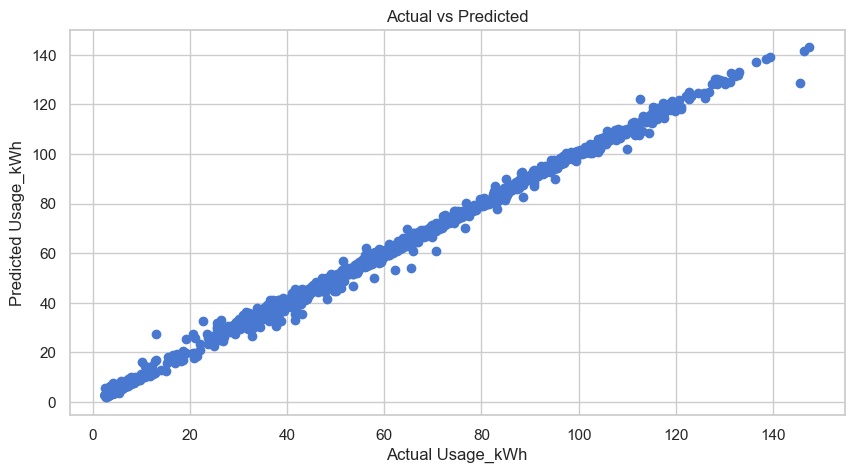

In [38]:
#Actual vs Prediccion

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Usage_kWh")
plt.ylabel("Predicted Usage_kWh")
plt.title("Actual vs Predicted")
plt.show()

In [40]:
import joblib
joblib.dump(xgb_model,"XGB_model_V0.pkl")

['XGB_model_V0.pkl']